In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO


# titles = '''sentiment, date, query, username, text'''
df = pd.read_csv('./dataset/sentiment140/data.csv', encoding='latin-1', header = None)
df.columns = ['sentiment', 'ID', 'date', 'query', 'username', 'text']

df = df.applymap(lambda s: s.lower() if type(s) == str else s)
df.head()

,sentiment,ID,date,query,username,text
0,0,1467810369,mon apr 06 22:19:45 pdt 2009,no_query,_thespecialone_,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,1467810672,mon apr 06 22:19:49 pdt 2009,no_query,scotthamilton,is upset that he can't update his facebook by ...
2,0,1467810917,mon apr 06 22:19:53 pdt 2009,no_query,mattycus,@kenichan i dived many times for the ball. man...
3,0,1467811184,mon apr 06 22:19:57 pdt 2009,no_query,ellectf,my whole body feels itchy and like its on fire
4,0,1467811193,mon apr 06 22:19:57 pdt 2009,no_query,karoli,"@nationwideclass no, it's not behaving at all...."


In [2]:
dfTrain = df.sample(frac = 0.8, random_state = 20)
dfTest = df.drop(dfTrain.index)

dfGraphModel = dfTrain.sample(frac = 0.5, random_state = 20)
dfDM = dfTrain.drop(dfGraphModel.index)

#subset of the dfTrain dataset, split into positive, negative, and neutral tweets
pos = dfGraphModel.loc[df['sentiment'] == 4]
neg = dfGraphModel.loc[df['sentiment'] == 0]
neut = dfGraphModel.loc[df['sentiment'] == 2]

posText = {line["ID"]: line["text"] for index, line in pos.iterrows()}
negText = {line["ID"]: line["text"] for index, line in neg.iterrows()}

posWords = [line.rstrip('\n') for line in open('./dataset/positive-words.txt') if line.split() and list(line)[0] != ';']
negWords = [line.rstrip('\n') for line in open('./dataset/negative-words.txt') if line.split() and list(line)[0] != ";"]

In [3]:
import re

def scoreTweet(wordDict, wordList):
    outputDict = {}
    for ID, text in wordDict.items():
        count = 0
        text = re.sub(r'[^\w\s]', '', str(text)).split()
        for word in text:
            if word in wordList:
                count += 1
        outputDict[ID] = count
    return outputDict

posCount = scoreTweet(posText, posWords)
negCount = scoreTweet(negText, negWords)

In [4]:
import operator
top5000Pos = [k for k, v in sorted(posCount.items(), key = operator.itemgetter(1), reverse = True)[:5000]]
top5000Neg = [k for k, v in sorted(negCount.items(), key = operator.itemgetter(1), reverse = True)[:5000]]

posGraphText = [posText[int(x)] for x in top5000Pos]
negGraphText = [negText[int(x)] for x in top5000Neg]

['is', 'upset', 'that', 'he', "can't", 'update', 'his', 'facebook', 'by', 'texting', 'it...', 'and', 'might', 'cry', 'as', 'a', 'result', 'school', 'today', 'also.', 'blah!']
[('is', 'upset'), ('is', 'that'), ('is', 'he'), ('upset', 'that'), ('upset', 'he'), ('upset', 'cant'), ('that', 'he'), ('that', 'cant'), ('that', 'update'), ('he', 'cant'), ('he', 'update'), ('he', 'his'), ('cant', 'update'), ('cant', 'his'), ('cant', 'facebook'), ('update', 'his'), ('update', 'facebook'), ('update', 'by'), ('his', 'facebook'), ('his', 'by'), ('his', 'texting'), ('facebook', 'by'), ('facebook', 'texting'), ('facebook', 'it'), ('by', 'texting'), ('by', 'it'), ('by', 'and'), ('texting', 'it'), ('texting', 'and'), ('texting', 'might'), ('it', 'and'), ('it', 'might'), ('it', 'cry'), ('and', 'might'), ('and', 'cry'), ('and', 'as'), ('might', 'cry'), ('might', 'as'), ('might', 'a'), ('cry', 'as'), ('cry', 'a'), ('cry', 'result'), ('as', 'a'), ('as', 'result'), ('as', 'school'), ('a', 'result'), ('a', 's

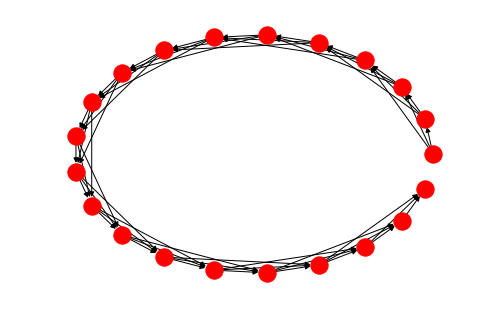

In [5]:
import networkx as nx
import re

# wordGraph = nx.DiGraph()

testTweet = str(df.loc[1, 'text'])

testTweet1 = re.sub(r'[^\w\s]', '', testTweet)

testTweet1 = testTweet.split()

print(testTweet1)


def createGraph(text, frame):
    if text:
        wordGraph = nx.DiGraph()
        text = re.sub(r'[^\w\s]', '', str(text))
        text = text.split()
        try:
            for x in range(len(text) - frame):
                for y in range(1, frame + 1):
                    wordGraph.add_edge(text[x], text[x+y])
            for x in reversed(range(1, frame + 1)):
                for y in reversed(range(1, x)):
                    wordGraph.add_edge(text[len(text) - x], text[len(text) - y])
        except IndexError:
            return createGraph(text, frame-1)
        return wordGraph
    else:
        return None

wordGraph = createGraph(testTweet, 3)
print(wordGraph.edges())

nx.draw_shell(wordGraph)

In [6]:
#generate average graph model of positive tweets
import numpy as np
posGraph = nx.DiGraph()

for element in posGraphText:
    graph = createGraph(element, 3)
    posGraph = nx.compose(posGraph, graph)

In [7]:
negGraph = nx.DiGraph()

for element in negGraphText:
    negGraph = nx.compose(createGraph(element, 3), negGraph)

In [8]:
print(len(negGraph.edges()))

151288


In [11]:
import pickle

dataArray = [posCount, negCount, top5000Pos, top5000Neg, posGraphText, negGraphText, posGraph, negGraph]

outfile = open('pickledData', 'wb')
pickle.dump(dataArray, outfile)
outfile.close()

In [ ]:
dfDM.loc[50000,:]

In [ ]:
# sampleText = dfDM.loc[50000,'text']
# sampleGraph = createGraph(sampleText, 3)
# print(nx.graph_edit_distance(sampleGraph, posGraph))